In [1]:
name1= "That'sIzumiko"
name2= "UchiNoNyan'sDiary"

def normalize_series_name(name):
    name = name.replace("'", "_")
    return name

name1= normalize_series_name(name1)
name2= normalize_series_name(name2)
print(name2)

UchiNoNyan_sDiary


In [2]:
import json

json_path= "data/MangaSegmentation/jsons_processed/Arisa.json"

with open (json_path, 'r') as f:
    json= json.load(f)

print(json.keys())

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])


In [3]:
json['annotations'][0]

{'id': 36844,
 'category_id': 1,
 'iscrowd': 0,
 'segmentation': [[54,
   38,
   52,
   40,
   52,
   572,
   54,
   574,
   460,
   574,
   462,
   572,
   462,
   40,
   460,
   38]],
 'image_id': 556,
 'area': 220695,
 'bbox': [52, 38, 411, 537]}

In [4]:
json['annotations'][0]['bbox']

[52, 38, 411, 537]

In [5]:
import os

img_path= 'data/Manga109_released_2023_12_07/images/Arisa/005.jpg'

img_name= os.path.basename(img_path)
series_name= os.path.basename(os.path.dirname(img_path))

img_name= os.path.join(series_name, img_name)
print(img_name)
print(series_name)

Arisa/005.jpg
Arisa


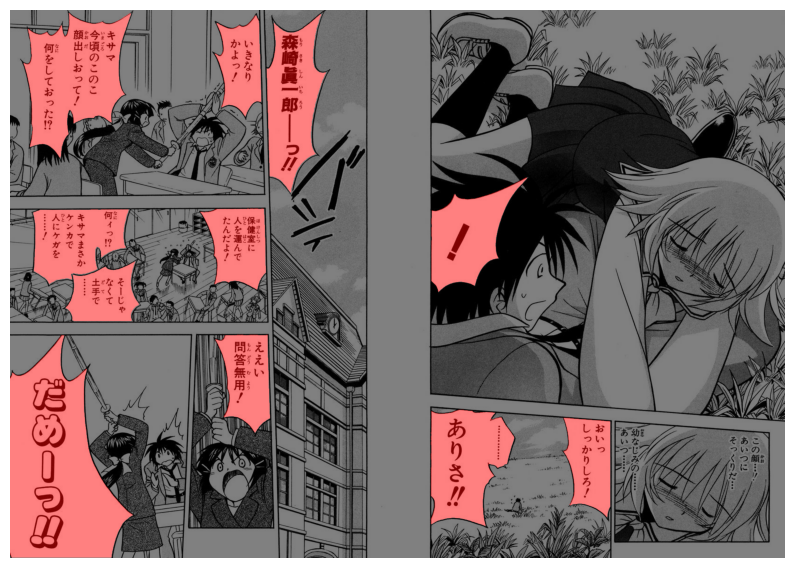

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
from pycocotools import mask as mask_utils
import numpy as np 

img_id= 0
masks= []
bboxes= []
for i in json['images']:
    if i['file_name']== img_name:
        img_id= i['id']
        org_img_h= i['height']
        org_img_w= i['width']

for ann in json['annotations']:
    if ann['category_id']==5 and ann['image_id']== img_id:
        masks.append(ann['segmentation'])
        bboxes.append(ann['bbox'])
        
mask_combined = np.zeros((org_img_h, org_img_w), dtype=bool)

for polygon in masks:
    rle = mask_utils.frPyObjects(polygon, org_img_h, org_img_w)
    mask = mask_utils.decode(rle)  # shape: H x W x N
    # check channel 2 (C) -> check true false -> copy mask
    mask_2d = np.any(mask, axis=2)  # gộp tất cả N component
    mask_combined = np.logical_or(mask_combined, mask_2d)
img= Image.open(img_path)
plt.figure(figsize=(10,10))
plt.imshow(img)

colored_mask = np.zeros((org_img_h, org_img_w, 3), dtype=np.uint8)
colored_mask[mask_combined] = [255,0,0]  # mask đỏ
plt.imshow(colored_mask, alpha=0.5)

plt.axis('off')
plt.show()

In [7]:
from ultralytics import YOLO

YOLO_MODEL_PATH = 'best.pt'
EX_IMG_PATH = 'data/Manga109_released_2023_12_07/images/Arisa/005.jpg'

model= YOLO(YOLO_MODEL_PATH)
results= model.predict(EX_IMG_PATH)

res= results[0]

print(res)


image 1/1 /home/hngoc/group-proj-b3/group-project-b3/data/Manga109_released_2023_12_07/images/Arisa/005.jpg: 480x640 11 balloons, 278.4ms
Speed: 2.8ms preprocess, 278.4ms inference, 7.3ms postprocess per image at shape (1, 3, 480, 640)
ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: ultralytics.engine.results.Masks object
names: {0: 'balloon'}
obb: None
orig_img: array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[243, 243, 243],
        [ 63,  63,

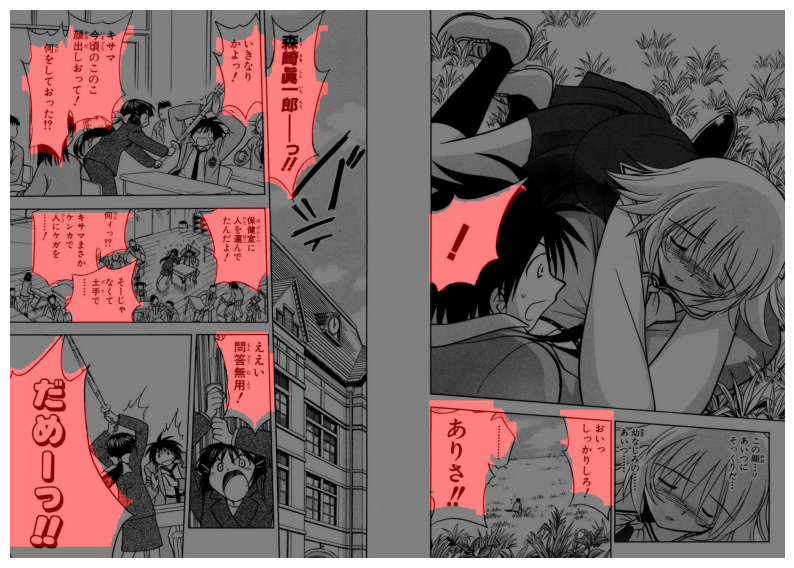

In [8]:
import cv2

pred_boxes = res.boxes.xyxy.cpu().numpy()  
pred_masks = res.masks.data.cpu().numpy()       # shape=(N, H, W)
pred_masks_resized=[]

for mask in pred_masks:  # mask shape: (H_model, W_model)
    # Resize về kích thước gốc
    mask_resized = cv2.resize(mask.astype(np.uint8), (org_img_w, org_img_h), interpolation=cv2.INTER_NEAREST)
    # Chuyển về bool
    mask_resized = mask_resized.astype(bool)
    pred_masks_resized.append(mask_resized)



plt.figure(figsize=(10,10))
plt.imshow(img)


colored_pred_mask = np.zeros((org_img_h, org_img_w, 3), dtype=np.uint8)

# Gộp tất cả mask thành 1 mask tổng
combined_pred_mask = np.any(pred_masks_resized, axis=0)  # shape (H,W), True nếu bất kỳ mask nào True
# Tạo overlay mask màu đỏ
colored_pred_mask = np.zeros_like(img)
colored_pred_mask[:,:,0] = combined_pred_mask.astype(np.uint8) * 255 

plt.imshow(colored_pred_mask, alpha=0.5)
plt.axis('off')
plt.show()

In [9]:
print(combined_pred_mask)
print(mask_combined)
print(pred_boxes)
print(bboxes)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False  True ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[[     29.564      4.9877       257.1      311.45]
 [     410.26      423.27      544.84      595.76]
 [     1180.2      868.72      1281.9      1078.5]
 [     898.77      853.17      1075.4      1104.3]
 [     440.55      693.06      554.55      900.88]
 [     548.92      4.4095      676.96      390.55]
 [     897.43      362.49      1099.6      597.81]
 [     440.37      7.5024      535.46      224.96]
 [    0.29018       704.6      265.53      1169.2]
 [     49.728

In [40]:
type(combined_pred_mask)

numpy.ndarray

In [41]:
type(mask_combined)

numpy.ndarray

In [44]:
type(pred_boxes[0])

numpy.ndarray

In [48]:
type(bboxes[0])

list

In [14]:
gt_bboxes_all = [ann["bbox"] for ann in train_json["annotations"]]
gt_seg_all = [ann["segmentation"] for ann in train_json["annotations"]]
print(gt_seg_all)

[[[488, 137, 487, 138, 487, 145, 488, 146, 494, 146, 495, 145, 496, 145, 497, 144, 497, 142, 496, 141, 494, 141, 490, 137]], [[153, 17, 140, 30, 139, 30, 136, 33, 135, 33, 133, 35, 132, 35, 131, 36, 130, 36, 129, 37, 127, 37, 125, 39, 123, 39, 122, 40, 118, 40, 117, 41, 107, 41, 106, 40, 104, 40, 102, 38, 101, 38, 92, 29, 92, 27, 91, 26, 91, 25, 88, 22, 87, 23, 87, 24, 86, 25, 86, 26, 85, 27, 85, 31, 83, 33, 83, 34, 82, 35, 82, 38, 80, 40, 80, 41, 70, 51, 69, 51, 68, 52, 67, 52, 64, 55, 62, 55, 60, 57, 58, 57, 57, 58, 56, 58, 55, 59, 54, 59, 53, 60, 49, 60, 48, 61, 42, 61, 41, 60, 38, 60, 36, 58, 35, 58, 34, 57, 33, 57, 32, 58, 32, 59, 34, 61, 34, 62, 35, 63, 35, 65, 36, 66, 36, 67, 37, 68, 37, 70, 39, 72, 39, 74, 40, 75, 40, 78, 41, 79, 41, 82, 42, 83, 42, 89, 43, 90, 43, 95, 44, 96, 44, 103, 45, 104, 45, 113, 46, 114, 46, 122, 47, 123, 47, 152, 46, 153, 46, 162, 45, 163, 45, 170, 44, 171, 44, 175, 43, 176, 43, 177, 42, 178, 42, 181, 40, 183, 40, 186, 38, 188, 38, 189, 37, 190, 37, 19

In [50]:
import json

train_json= "train.json"
with open (train_json, 'r') as f:
    data= json.load(f)

for ann in data['annotations']:
    if ann['category_id']==1:
        print(ann['bbox'])

[487, 137, 11, 10]
[23, 17, 162, 267]
[545, 17, 102, 196]
[616, 390, 154, 170]
[275, 391, 130, 193]
[105, 392, 158, 111]
[64, 1035, 131, 117]
[1429, 0, 225, 457]
[588, 1, 173, 240]
[300, 31, 76, 93]
[33, 263, 87, 141]
[591, 456, 170, 153]
[321, 457, 125, 207]
[74, 470, 72, 99]
[890, 523, 153, 218]
[1432, 523, 201, 239]
[0, 794, 151, 217]
[413, 794, 33, 70]
[266, 795, 74, 154]
[166, 802, 114, 168]
[1376, 822, 268, 254]
[889, 836, 114, 216]
[1247, 852, 108, 167]
[136, 46, 76, 115]
[430, 65, 116, 170]
[587, 66, 40, 58]
[33, 162, 82, 129]
[551, 183, 46, 72]
[621, 304, 138, 302]
[25, 318, 142, 192]
[597, 579, 57, 76]
[303, 893, 92, 132]
[183, 940, 111, 150]
[29, 9, 230, 309]
[548, 11, 127, 381]
[437, 14, 100, 216]
[899, 359, 205, 245]
[406, 425, 141, 174]
[50, 427, 204, 160]
[119, 538, 157, 128]
[438, 694, 118, 210]
[0, 695, 263, 475]
[898, 854, 179, 249]
[1181, 871, 101, 213]
[630, 0, 128, 395]
[1401, 0, 253, 545]
[169, 740, 193, 184]
[1489, 858, 96, 152]
[1381, 860, 120, 135]
[41, 913, 64